## Forecasting forex using ARIMA for USD/VND 
The purpose of this research is to forecast usd/vnd exchamge rate to use in our investment analysis.

# Import packages

In [11]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from pandas import DataFrame
from matplotlib import pyplot
from pmdarima.arima import auto_arima
from datetime import datetime
from sklearn.metrics import mean_squared_error

%matplotlib inline

# Set figure parameters
plt.rcParams['figure.figsize'] = [10, 7.5]

## Input data

C:\Users\snurzahirah\AppData\Local\Temp\ipykernel_31040\3743076777.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(filepath, parse_dates=['Date'])


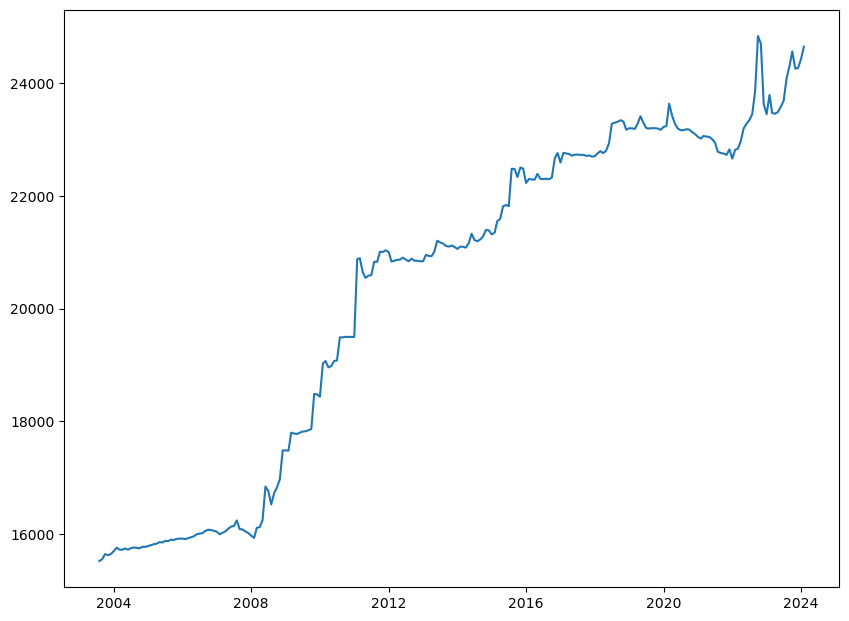

In [12]:
# Filepath to the CSV file
filepath = r"C:\Users\snurzahirah\Desktop\Clone\FinalisedData.csv"

# Read the CSV file, specifying the date format
data = pd.read_csv(filepath, parse_dates=['Date'])

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Retaining only wanted data
data = data[['FX Rate']]

# Drop rows with NaN values
data.dropna(inplace=True)

# Format data
data.index = pd.to_datetime(data.index, format='%b-%y')
data = data.sort_index()

# Plot data
plt.plot(data)

## Stationary test

For ARIMA, we need to make sure the data we input is stationary. The ACF and PACF plots can help us determine that visually. On a more detailed level, the ADF test gives us a p-value to help gauge stationarity. 

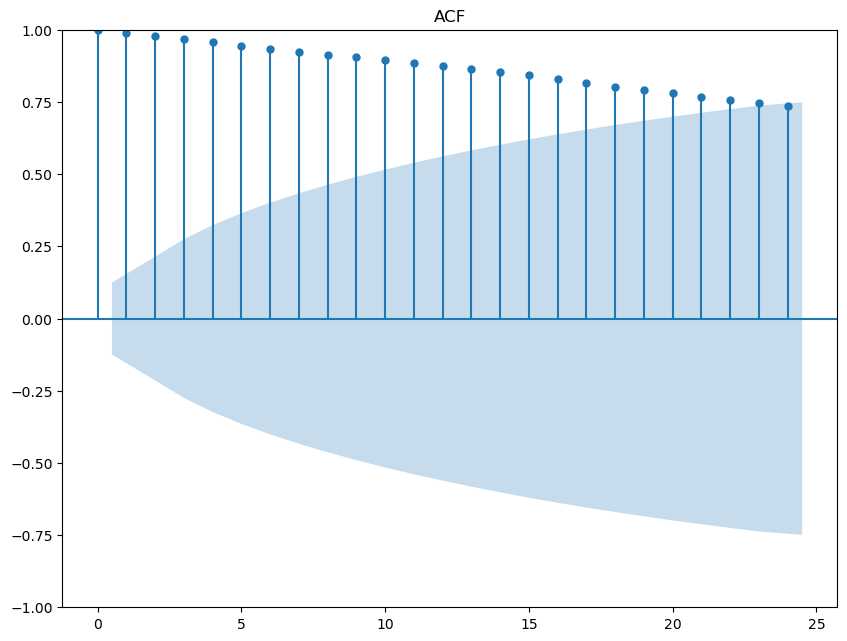

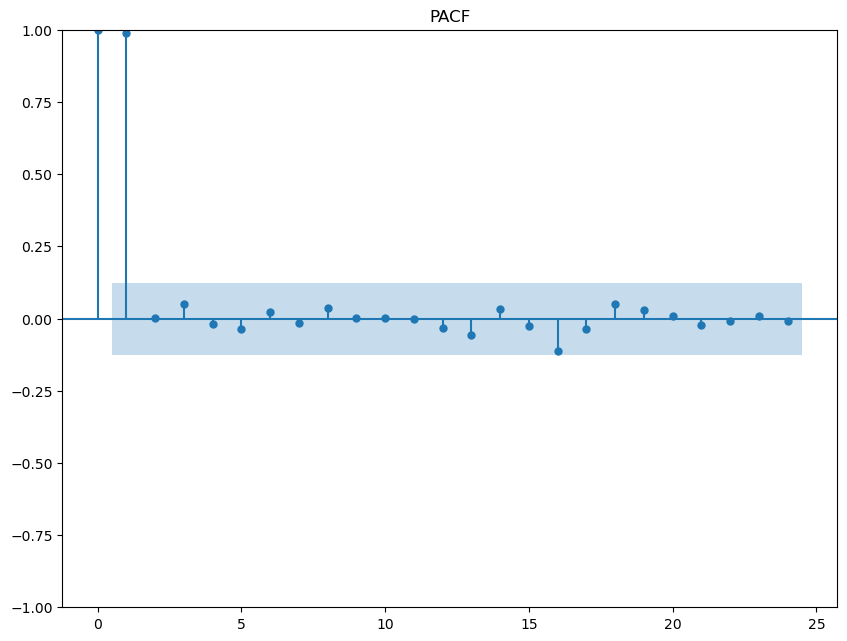

In [13]:
# Autocorrelation and partial correlation function of data
plot_acf(data)
plt.title("ACF")
plot_pacf(data)
plt.title("PACF")
plt.show()

In [14]:
adftest = adfuller(data, autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")


ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -1.457504994722432
P-Value: 0.8432337779612702
Number of lags: 11
Number of observations: 235
Critical Values: {'1%': -3.997818933858586, '5%': -3.4293396709977557, '10%': -3.13812535054853}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


## Differencing 

Based on the ACF and PACF plots as well as the ADF results, our data is not stationary. Hence, we carry out differencing to remove non-stationarities. 

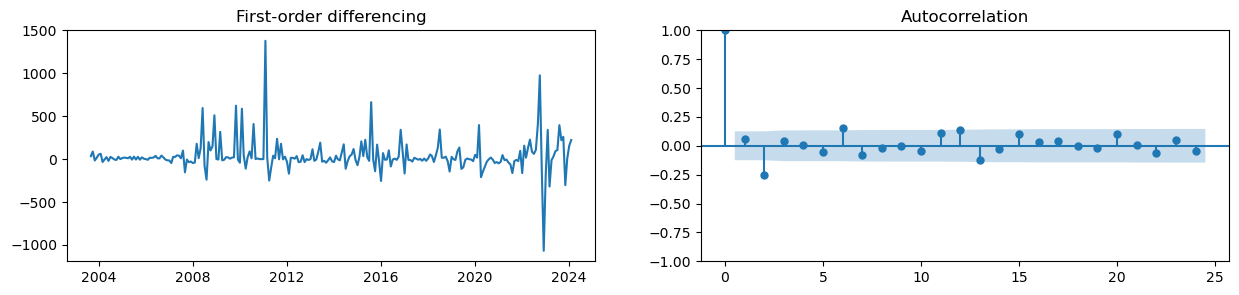

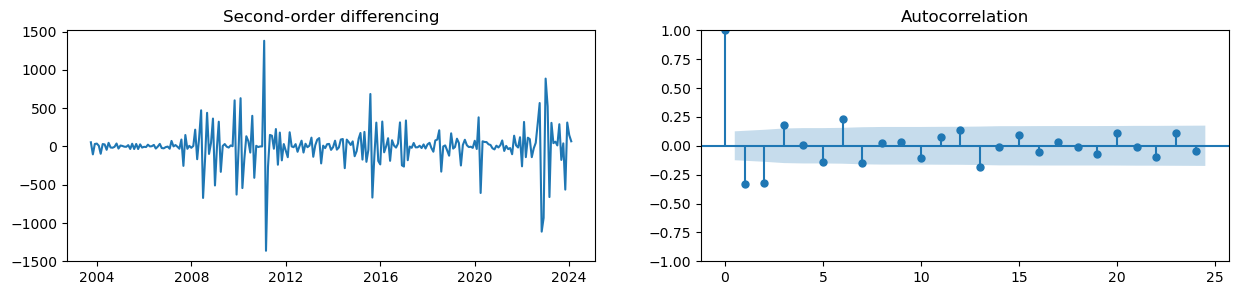

In [15]:
# First-order differencing
data['diff1'] = data.diff().dropna()
f = plt.figure(figsize=(15,3))
ax1 = f.add_subplot(121)
ax1.set_title('First-order differencing')
ax1.plot(data['diff1'])

data['growth_1'] = data['diff1']*100 # Convert first-order difference to growth rates by mutiplying by 100
ax2 = f.add_subplot(122)
plot_acf(data['diff1'].dropna(), ax=ax2)
plt.show()

# Second order differencing
data['diff2'] = data['FX Rate'].diff().diff().dropna()
f = plt.figure(figsize=(15,3))
ax1 = f.add_subplot(121)
ax1.set_title('Second-order differencing')
ax1.plot(data['diff2'])

data['growth_2'] = data['diff2']*100 # Convert first-order difference to growth rates by mutiplying by 100
ax2 = f.add_subplot(122)
plot_acf(data['diff2'].dropna(), ax=ax2)
plt.show()



In [16]:
# Test stationarity with ADF
adftest = adfuller(data['growth_1'].dropna(), autolag = 'AIC', regression = 'n')
print("ADF Test Results")
print("Null Hypothesis: The series has an Unit Root")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null Hypothesis and the series is Stationary")


ADF Test Results
Null Hypothesis: The series has an Unit Root
ADF-Statistic: -3.1806031971717132
P-Value: 0.0014706193449055753
Number of lags: 10
Number of observations: 235
Critical Values {'1%': -2.5753197193300137, '5%': -1.9422015054082429, '10%': -1.6157369772401105}
Note: If P-Value is smaller than 0.05, we reject the null Hypothesis and the series is Stationary


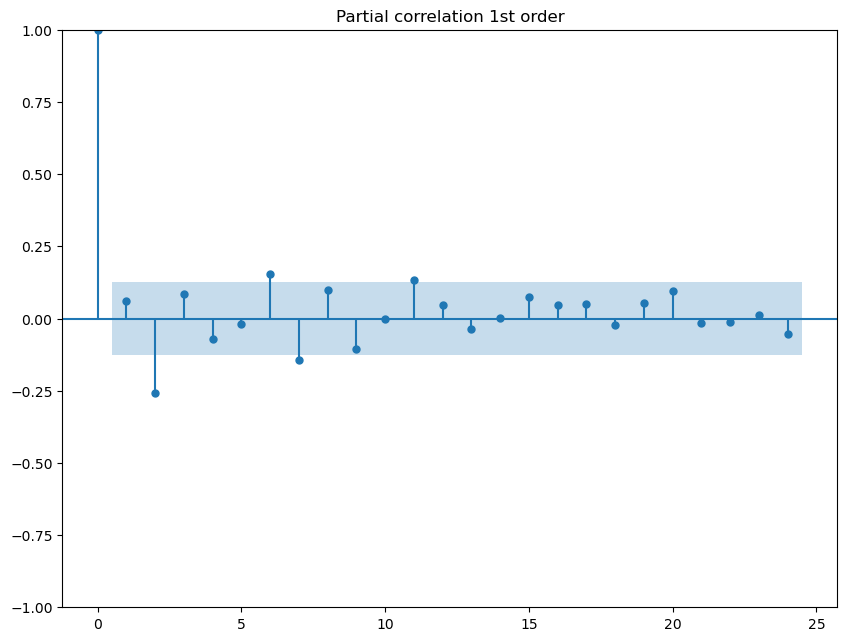

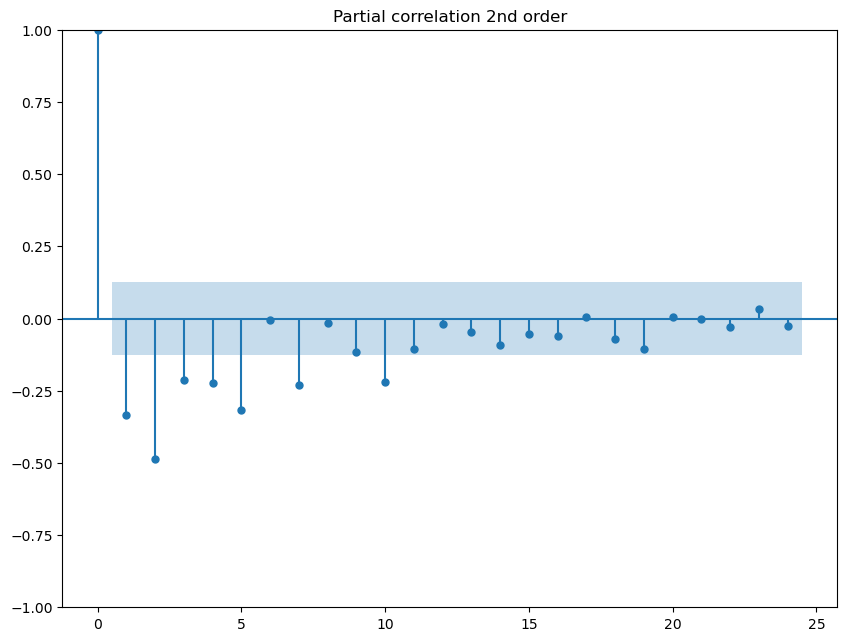

In [17]:
# Partial autocorrelation
plot_pacf(data['diff1'].dropna(),method='ywm')
plt.title('Partial correlation 1st order')
plt.show()

plot_pacf(data['diff2'].dropna(),method='ywm')
plt.title('Partial correlation 2nd order')
plt.show()

# ARIMA model parameters

Once the model is satisfactorily stationary, we can move towards prepping the data for training. So the data is split into 2/3 train data, and 1/3 test data.

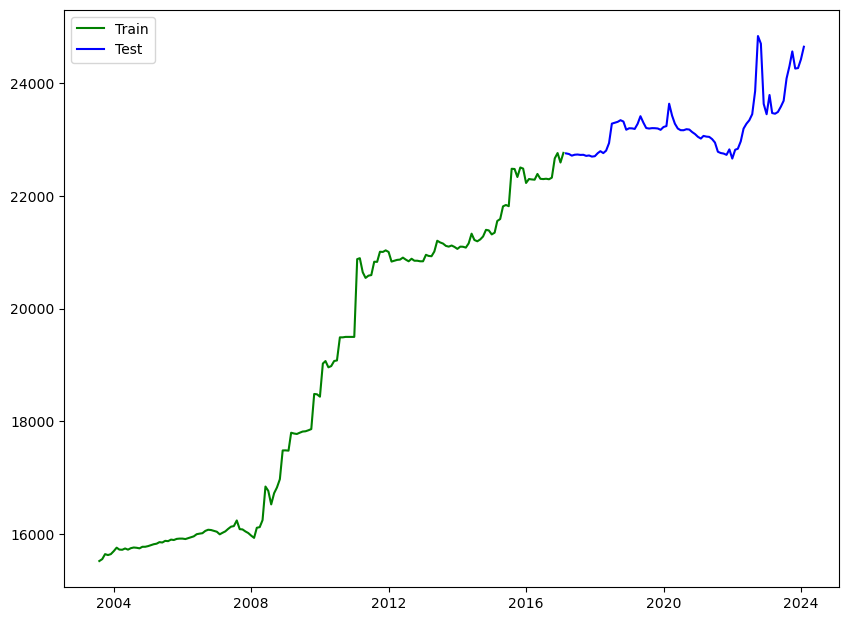

In [18]:
# Seperate into train and test data
to_row = int(len(data)*0.66)

df_train = list(data[0:to_row]['FX Rate'])
df_test = list(data[to_row:]['FX Rate'])

# Plot
plt.plot(data[0:to_row]['FX Rate'], 'green', label='Train')
plt.plot(data[to_row:]['FX Rate'],'blue',label='Test')
plt.legend()
plt.show()

The auto_arima function helps us find the hyperparameters for the arima model automatically. It serves as a preliminary guideline. 

In [19]:
# Finding ARIMA parameters automatically
model = auto_arima(data[0:to_row]['diff1'].dropna(), seasonal=False, stepwise= False, d= None, suppress_warnings=True)
print(model.order)

(2, 0, 2)


The auto_arima function suggests (2,0,2), but because we used first difference, we'll input (2,1,2) into our model. Note that we are appending the test value at each iteration for back-testing purposes. 

In [29]:
data[to_row:]['FX Rate'].index

DatetimeIndex(['2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01',
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01',
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
      

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  247
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1623.130
Date:                Wed, 15 May 2024   AIC                           3256.260
Time:                        15:15:33   BIC                           3273.787
Sample:                             0   HQIC                          3263.317
                                - 247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0700      0.168     -6.380      0.000      -1.399      -0.741
ar.L2         -0.7080      0.102     -6.918      0.000      -0.909      -0.507
ma.L1          1.2652      0.156      8.132      0.0

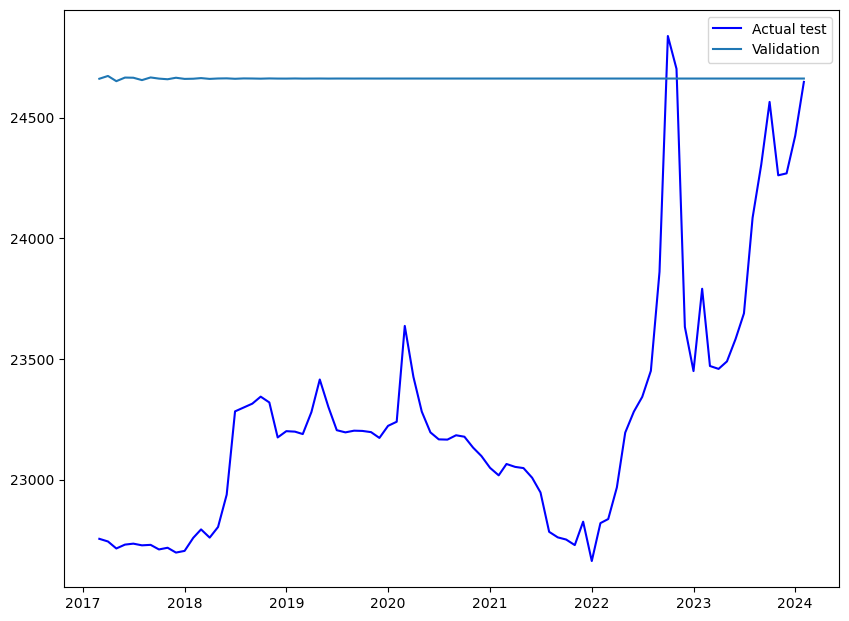

In [48]:
p = 2
d = 1
q = 2

model = ARIMA(df_train, order=(p,d,q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Plot residuals
#residuals = pd.DataFrame(model_fit.resid)
#residuals.plot(title='Residuals')
#plt.show()

# Plot actual vs. predicted values
#plt.plot(data[0:to_row]['FX Rate'], 'green', label='Train')
plt.plot(data[to_row:]['FX Rate'],'blue',label='Actual test')
plt.plot(data[to_row:]['FX Rate'].index, model_fit.forecast(len(df_test)), label='Validation')
plt.legend()
plt.show()

In [36]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  163
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1058.271
Date:                Wed, 15 May 2024   AIC                           2126.542
Time:                        15:10:32   BIC                           2141.980
Sample:                             0   HQIC                          2132.810
                                - 163                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0864      0.100    -10.811      0.000      -1.283      -0.889
ar.L2         -0.8816      0.108     -8.168      0.000      -1.093      -0.670
ma.L1          1.1430      0.115      9.977      0.000       0.918       1.367
ma.L2          0.8001      0.121      6.622      0.000       0.563       1.037
sigma2      2.733e+04   1619.602     16.872      0.000    2.42e+04    3.05e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):              4673.51
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               7.99   Skew:                             3.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Evaluate model predictions

In [39]:
testScore = np.sqrt(mean_squared_error(df_test, model_fit.forecast(len(df_test))))

testScore = testScore

print('Test Score: %.6f RMSE' % (testScore))

rmspe = (np.sqrt(np.mean(np.square(np.subtract(df_test,model_predictions) / df_test)))) * 100
print('Test Score: %.6f RMSPE' % (rmspe))

Test Score: 717.396377 RMSE
Test Score: 2.978875 RMSPE


# Back testing

In [44]:
model_predictions = []
n_test_obser = len(df_test)

p = 2
d = 1
q = 2

for i in range(n_test_obser):
    model = ARIMA(df_train, order=(p,d,q))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = list(output)
    model_predictions.append(yhat)
    actual_test_value = df_test[i]
    df_train.append(actual_test_value)

In [45]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  246
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1615.988
Date:                Wed, 15 May 2024   AIC                           3241.976
Time:                        15:14:49   BIC                           3259.483
Sample:                             0   HQIC                          3249.026
                                - 246                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0642      0.152     -6.989      0.000      -1.363      -0.766
ar.L2         -0.7249      0.096     -7.527      0.000      -0.914      -0.536
ma.L1          1.2504      0.142      8.804      0.000       0.972       1.529
ma.L2          0.7271      0.123      5.894      0.000       0.485       0.969
sigma2      3.109e+04   1165.554     26.676      0.000    2.88e+04    3.34e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):              3722.40
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                             2.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

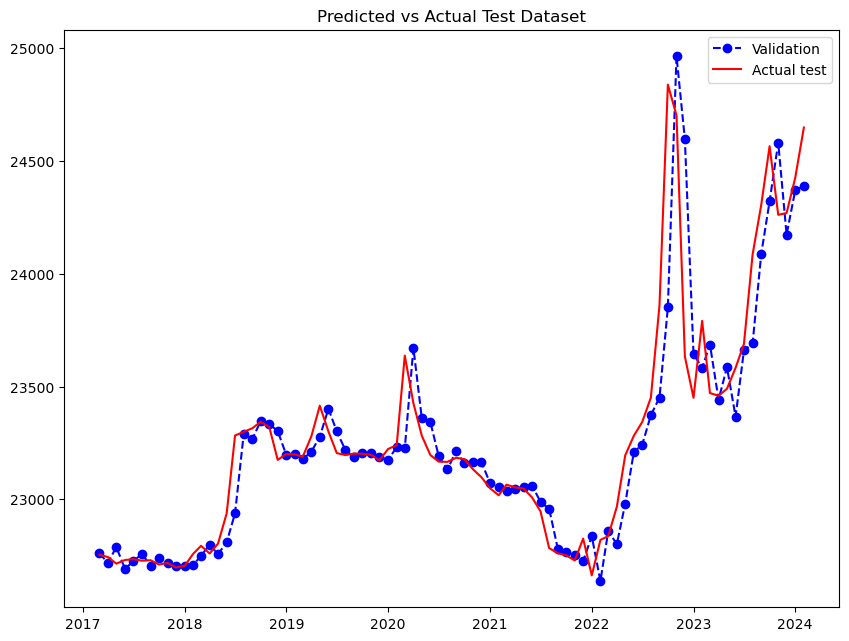

In [49]:
date_range = data[to_row:].index
plt.plot(date_range, model_predictions, color = 'blue', marker = 'o', linestyle = 'dashed', label = 'Validation')
plt.plot(date_range, df_test, color = 'red', label = 'Actual test')
plt.legend()
plt.title('Predicted vs Actual Test Dataset')
plt.show()

## Evaluate model predictions

In [55]:
testScore = np.sqrt(mean_squared_error(df_test, model_predictions))

testScore = testScore

print('Test Score: %.6f RMSE' % (testScore))

rmspe = (np.sqrt(np.mean(np.square(np.subtract(df_test,model_predictions) / df_test)))) * 100
print('Test Score: %.6f RMSPE' % (rmspe))

Test Score: 202.926234 RMSE
Test Score: 2.986148 RMSPE


# Forecast into the future

When we get a reasonable RMSE value, we can use the trained model to forecast forward.

In [50]:
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

print("Forecasted values:")
print(forecast)

Forecasted values:
[24661.00529249 24672.58450353 24650.98658249 24665.89928403
 24665.23323951 24655.38783792 24666.39439865 24661.58738455
 24658.93852238 24665.17625491 24660.37698897 24661.09613602]


We add the forecasted value into a dataframe to plot with the train and test value

In [51]:
from pandas.tseries.offsets import DateOffset

future_dates = [data.index[-1] + DateOffset(months = x) for x in range (0,forecast_steps+1)]
future_dates_df = pd.DataFrame(index = future_dates[1:], columns = data.columns)
comb_df = pd.concat([data[to_row:], future_dates_df])

C:\Users\snurzahirah\AppData\Local\Temp\ipykernel_31040\3607671743.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comb_df = pd.concat([data[to_row:], future_dates_df])


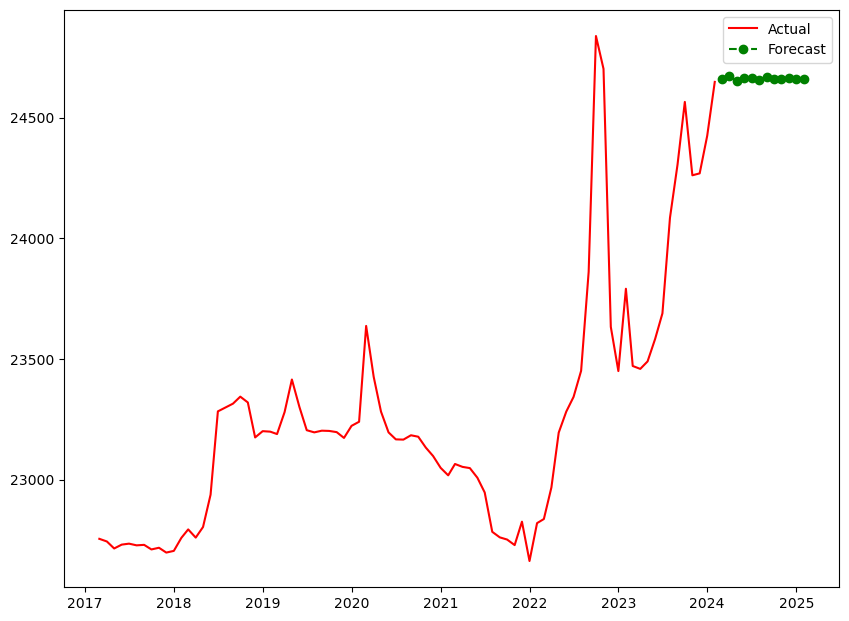

In [52]:
plt.plot(data[to_row:].index, data[to_row:]['FX Rate'], color = 'red', label = 'Actual')
plt.plot(future_dates_df.index, forecast, color = 'green', marker = 'o', linestyle = 'dashed', label = 'Forecast')
plt.legend()

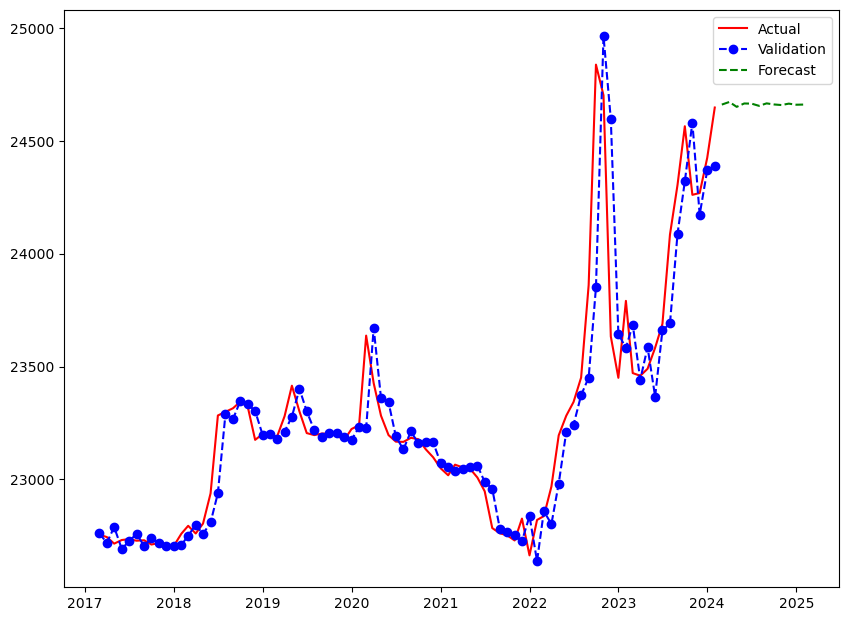

In [53]:
plt.plot(data[to_row:].index, data[to_row:]['FX Rate'], color = 'red', label = 'Actual')
plt.plot(data[to_row:].index, model_predictions, color = 'blue', marker = 'o', linestyle = 'dashed', label = 'Validation')
plt.plot(future_dates_df.index, forecast, color = 'green', linestyle = 'dashed', label = 'Forecast')
plt.legend()